# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D, UpSampling2D # type: ignore
from tensorflow.keras.models import Model, load_model # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # type: ignore
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Helper Functions

In [2]:
def get_peak_coordinates(matrix):
    matrix_2d = matrix.squeeze()
    idx = np.unravel_index(np.argmax(matrix_2d), matrix_2d.shape)
    return idx

def isolate_peak(matrix):
    mat = matrix.squeeze()
    clean = np.zeros_like(mat)
    peak_idx = np.unravel_index(np.argmax(mat), mat.shape)
    clean[peak_idx] = mat[peak_idx]
    return clean

def normalize_matrix(mat):
    return (mat - np.mean(mat)) / (np.std(mat) + 1e-5)

# Load and Preprocess Training Data

In [3]:
# Load and process data
dataset_dirs = [
    "/Users/alexahitov/Desktop/arduino/Pressure Pad/training_set_0",
    "/Users/alexahitov/Desktop/arduino/Pressure Pad/training_set_1",
    "/Users/alexahitov/Desktop/arduino/Pressure Pad/training_set_2",
    "/Users/alexahitov/Desktop/arduino/Pressure Pad/training_set_3",
    "/Users/alexahitov/Desktop/arduino/Pressure Pad/training_set_4",
    "/Users/alexahitov/Desktop/arduino/Pressure Pad/training_set_5"
]

X, Y_clean = [], []

for dataset_dir in dataset_dirs:
    for fname in sorted(os.listdir(dataset_dir)):
        if fname.endswith(".npy"):
            matrix = np.load(os.path.join(dataset_dir, fname)).astype("float32") / 4095.0
            X.append(matrix)

            x, y, _ = map(int, fname[:-4].split("_"))
            clean = np.zeros_like(matrix)
            clean[y, x] = matrix[y, x]
            Y_clean.append(clean)

X = np.array(X)
Y_clean = np.array(Y_clean)

X = np.array([normalize_matrix(m) for m in X])[..., np.newaxis]
Y_clean = np.array([normalize_matrix(m) for m in Y_clean])[..., np.newaxis]

# Load and Preprocess No-Touch Data

In [4]:
# Load no-touch samples
no_touch_dir = "/Users/alexahitov/Desktop/arduino/Pressure Pad/no_touch_set"

X_no_touch, Y_no_touch = [], []

for fname in sorted(os.listdir(no_touch_dir)):
    if fname.endswith(".npy"):
        matrix = np.load(os.path.join(no_touch_dir, fname)).astype("float32") / 4095.0
        X_no_touch.append(matrix)

        # Create clean all-zero target
        clean = np.zeros_like(matrix)
        Y_no_touch.append(clean)

# Normalize and reshape
X_no_touch = np.array([normalize_matrix(m) for m in X_no_touch])[..., np.newaxis]
Y_no_touch = np.array([normalize_matrix(m) for m in Y_no_touch])[..., np.newaxis]

# Combine normal and no-touch data
X_total = np.concatenate([X, X_no_touch], axis=0)
Y_total = np.concatenate([Y_clean, Y_no_touch], axis=0)

# Build and Train Denoising Autoencoder

In [ ]:
# Modified loss function
def focused_peak_loss(y_true, y_pred):
    # Masks
    peak_mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)
    suppress_mask = 1.0 - peak_mask

    # Counts (avoid division by 0)
    peak_count = tf.reduce_sum(peak_mask, axis=[1,2,3])
    suppress_count = tf.reduce_sum(suppress_mask, axis=[1,2,3])
    peak_count = tf.maximum(peak_count, 1.0)
    suppress_count = tf.maximum(suppress_count, 1.0)

    # Terms
    peak_mse = tf.reduce_sum(peak_mask * tf.square(y_true - y_pred), axis=[1,2,3]) / peak_count
    suppress_loss = tf.reduce_sum(suppress_mask * tf.square(y_pred), axis=[1,2,3]) / suppress_count
    reinforce = tf.reduce_sum(peak_mask * y_pred, axis=[1,2,3]) / peak_count

    # Final loss
    return 5.0 * peak_mse + 4.0 * suppress_loss - 1.0 * reinforce

# Build Model
input_layer = Input(shape=(6, 6, 1))

x = Conv2D(32, (4, 2), padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (4, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(8, (4, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), padding='same', dilation_rate=2, activation='relu')(x)
x = Conv2D(1, (2, 2), activation='linear', padding='same')(x)

autoencoder = Model(input_layer, x)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
autoencoder.compile(optimizer=optimizer, loss=focused_peak_loss, metrics=["mae"])

# Callbacks
callbacks = [
    EarlyStopping(patience=500, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_autoencoder_0.h5", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=500, verbose=1, min_lr=1e-6)
]

# Train-validation split (include *all* samples in val)
train_idx, val_idx = train_test_split(np.arange(len(Y_total)), test_size=0.1, random_state=42)

X_train, Y_train = X_total[train_idx], Y_total[train_idx]
X_val, Y_val = X_total[val_idx], Y_total[val_idx]

# Train
history = autoencoder.fit(
    X_train, Y_train,
    epochs=4000,
    batch_size=8,
    validation_data=(X_val, Y_val),
    callbacks=callbacks,
    verbose=1
)

# Compute Validation Accuracy

In [279]:
# Predict on validation data
decoded_samples = autoencoder.predict(X_val)

correct = sum(
    get_peak_coordinates(Y_val[i]) == get_peak_coordinates(decoded_samples[i])
    for i in range(len(Y_val))
)

accuracy = correct / len(Y_val)
print(f"Validation Accuracy: {accuracy:.2%}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step 
Validation Accuracy: 59.45%


# Visulailze the Model Output

In [246]:
def print_matrices(i, X, Y_true, model):
    pred = model.predict(X[i:i+1])[0].squeeze()
    true = Y_true[i].squeeze()
    inp = X[i].squeeze()

    np.set_printoptions(precision=4, suppress=True)

    print(f"\nInput Matrix (#{i}):\n{inp}")
    print(f"\nGround Truth Matrix (#{i}):\n{true}")
    print(f"\nPredicted Matrix (#{i}):\n{pred}")

def plot_training_error_heatmap(X_train, Y_train, model, threshold=0.5):
    grid_size = (6, 6)
    total_counts = np.zeros(grid_size)
    incorrect_counts = np.zeros(grid_size)

    predictions = model.predict(X_train)

    for i in range(len(X_train)):
        pred = predictions[i].squeeze()
        true = Y_train[i].squeeze()

        if np.max(true) < 1e-3:
            continue  # Skip no-touch samples

        true_pos = np.unravel_index(np.argmax(true), grid_size)
        pred_pos = np.unravel_index(np.argmax(pred), grid_size)

        total_counts[true_pos] += 1

        dist = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
        if dist > threshold:
            incorrect_counts[true_pos] += 1

    error_rates = np.divide(
        incorrect_counts, total_counts,
        out=np.zeros_like(incorrect_counts), where=total_counts != 0
    )

    plt.figure(figsize=(6, 5))
    plt.imshow(error_rates, cmap="Reds", origin="lower")
    plt.colorbar(label="Training Error Rate")
    plt.title(f"Training Error Rate Heatmap (Threshold: {threshold} units)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.xticks(np.arange(6))
    plt.yticks(np.arange(6))
    plt.grid(False)
    plt.show()

    return error_rates

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step

Input Matrix (#0):
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

Ground Truth Matrix (#0):
[[-0.1353 -0.1353 -0.1353 -0.1353 -0.1353 -0.1353]
 [-0.1353 -0.1353 -0.1353 -0.1353 -0.1353 -0.1353]
 [-0.1353 -0.1353 -0.1353 -0.1353 -0.1353 -0.1353]
 [-0.1353 -0.1353 -0.1353 -0.1353 -0.1353 -0.1353]
 [ 4.736  -0.1353 -0.1353 -0.1353 -0.1353 -0.1353]
 [-0.1353 -0.1353 -0.1353 -0.1353 -0.1353 -0.1353]]

Predicted Matrix (#0):
[[1.565  1.5658 1.5134 1.5142 1.4598 1.467 ]
 [1.5696 1.5729 1.5199 1.5166 1.463  1.4662]
 [1.5181 1.5192 1.4454 1.4457 1.4267 1.4334]
 [1.5192 1.514  1.4414 1.4421 1.4231 1.4343]
 [1.5059 1.5062 1.4858 1.4862 1.4647 1.4719]
 [1.5535 1.5514 1.5315 1.5292 1.5082 1.4609]]
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


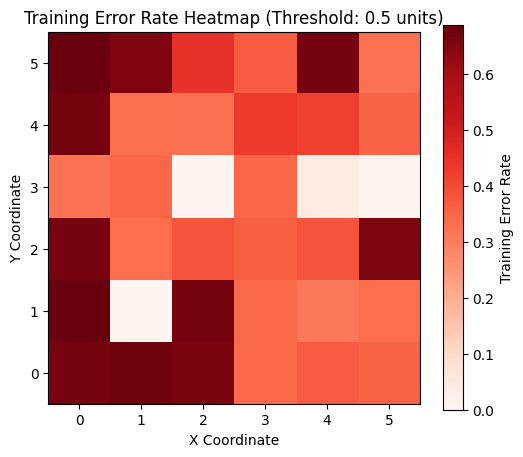

array([[0.6636, 0.6729, 0.6606, 0.3394, 0.3704, 0.3551],
       [0.6875, 0.    , 0.6635, 0.3458, 0.3119, 0.3364],
       [0.6636, 0.3364, 0.3832, 0.3611, 0.3818, 0.6571],
       [0.3243, 0.3486, 0.    , 0.3486, 0.036 , 0.    ],
       [0.6667, 0.3333, 0.3302, 0.4299, 0.419 , 0.3551],
       [0.6818, 0.6545, 0.4486, 0.3679, 0.6635, 0.3273]])

In [262]:
print_matrices(0, X_train, Y_train, autoencoder)

plot_training_error_heatmap(X_train, Y_train, autoencoder, threshold=0.5)

# Plot Validation Predictions

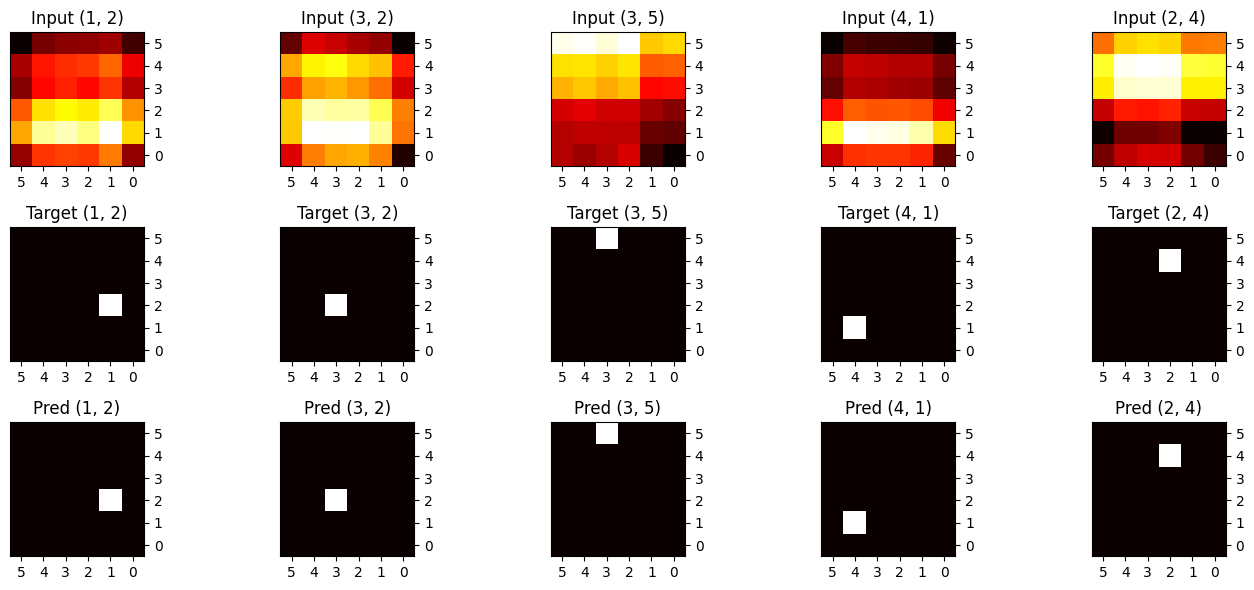

In [248]:
# Choose random samples (or replace with any list of indices you want)
sample_indices = np.random.choice(len(Y_val), size=min(5, len(Y_val)), replace=False)
n = len(sample_indices)
plt.figure(figsize=(14, 6))

for j, i in enumerate(sample_indices):
    true_y, true_x = np.unravel_index(np.argmax(Y_val[i]), Y_val[i].shape[:2])
    pred_y, pred_x = get_peak_coordinates(decoded_samples[i])

    # Input
    ax1 = plt.subplot(3, n, j + 1)
    ax1.imshow(X_val[i].squeeze(), cmap="hot")
    ax1.set_title(f"Input ({true_x}, {true_y})")
    ax1.set_xticks(range(6))
    ax1.set_yticks(range(6))
    ax1.set_xticklabels(list(reversed(range(6))))
    ax1.set_yticklabels(list(reversed(range(6))))
    ax1.yaxis.tick_right()

    # Target
    ax2 = plt.subplot(3, n, j + 1 + n)
    ax2.imshow(np.fliplr(Y_val[i].squeeze()), cmap="hot", origin="lower")
    ax2.set_title(f"Target ({true_x}, {true_y})")
    ax2.set_xticks(range(6))
    ax2.set_yticks(range(6))
    ax2.set_xticklabels(list(reversed(range(6))))
    ax2.set_yticklabels(list(range(6)))
    ax2.yaxis.tick_right()

    # Prediction
    ax3 = plt.subplot(3, n, j + 1 + 2*n)
    ax3.imshow(np.fliplr(isolate_peak(decoded_samples[i])), cmap="hot", origin="lower")
    ax3.set_title(f"Pred ({pred_x}, {pred_y})")
    ax3.set_xticks(range(6))
    ax3.set_yticks(range(6))
    ax3.set_xticklabels(list(reversed(range(6))))
    ax3.set_yticklabels(list(range(6)))
    ax3.yaxis.tick_right()

plt.tight_layout()
plt.show()

# Test Model Against External Data

In [11]:
# Load the Data
def load_external_test_set(test_dir):
    X_ext, Y_ext_clean = [], []
    for fname in sorted(os.listdir(test_dir)):
        if fname.endswith(".npy"):
            matrix = np.load(os.path.join(test_dir, fname)).astype("float32") / 4095.0
            x, y, _ = map(int, fname[:-4].split("_"))
            clean = np.zeros_like(matrix)
            clean[y, x] = matrix[y, x]

            X_ext.append(normalize_matrix(matrix))
            Y_ext_clean.append(normalize_matrix(clean))

    X_ext = np.array(X_ext)[..., np.newaxis]
    Y_ext_clean = np.array(Y_ext_clean)[..., np.newaxis]
    return X_ext, Y_ext_clean

# Plot Samples
def plot_external_predictions(X_ext, Y_ext_clean, decoded_ext, output_prefix):
    n = min(5, len(X_ext))
    indices = np.random.choice(len(X_ext), size=n, replace=False)

    plt.figure(figsize=(14, 6))
    for j, i in enumerate(indices):
        true_y, true_x = get_peak_coordinates(Y_ext_clean[i])
        pred_y, pred_x = get_peak_coordinates(decoded_ext[i])

        ax1 = plt.subplot(3, n, j + 1)
        ax1.imshow(X_ext[i].squeeze(), cmap="hot")
        ax1.set_title(f"Input ({true_x}, {true_y})")
        ax1.set_xticks(range(6)); ax1.set_yticks(range(6))
        ax1.set_xticklabels(list(reversed(range(6)))); ax1.set_yticklabels(list(reversed(range(6))))
        ax1.yaxis.tick_right()

        ax2 = plt.subplot(3, n, j + 1 + n)
        ax2.imshow(np.fliplr(Y_ext_clean[i].squeeze()), cmap="hot", origin="lower")
        ax2.set_title(f"Target ({true_x}, {true_y})")
        ax2.set_xticks(range(6)); ax2.set_yticks(range(6))
        ax2.set_xticklabels(list(reversed(range(6)))); ax2.set_yticklabels(list(range(6)))
        ax2.yaxis.tick_right()

        ax3 = plt.subplot(3, n, j + 1 + 2 * n)
        ax3.imshow(np.fliplr(isolate_peak(decoded_ext[i])), cmap="hot", origin="lower")
        ax3.set_title(f"Pred ({pred_x}, {pred_y})")
        ax3.set_xticks(range(6)); ax3.set_yticks(range(6))
        ax3.set_xticklabels(list(reversed(range(6)))); ax3.set_yticklabels(list(range(6)))
        ax3.yaxis.tick_right()
    plt.tight_layout()
    plt.show()

# Save PDF
def save_predictions_pdf(X_ext, Y_ext_clean, decoded_ext, filename):
    n = len(X_ext)
    plt.figure(figsize=(12, 3 * n))
    for i in range(n):
        true_y, true_x = get_peak_coordinates(Y_ext_clean[i])
        pred_y, pred_x = get_peak_coordinates(decoded_ext[i])

        ax1 = plt.subplot(n, 3, 3*i + 1)
        ax1.imshow(X_ext[i].squeeze(), cmap="hot")
        ax1.set_title(f"Input ({true_x}, {true_y})")
        ax1.set_xticks(range(6)); ax1.set_yticks(range(6))
        ax1.set_xticklabels(list(reversed(range(6)))); ax1.set_yticklabels(list(reversed(range(6))))
        ax1.yaxis.tick_right()

        ax2 = plt.subplot(n, 3, 3*i + 2)
        ax2.imshow(np.fliplr(Y_ext_clean[i].squeeze()), cmap="hot", origin="lower")
        ax2.set_title(f"Target ({true_x}, {true_y})")
        ax2.set_xticks(range(6)); ax2.set_yticks(range(6))
        ax2.set_xticklabels(list(reversed(range(6)))); ax2.set_yticklabels(list(range(6)))
        ax2.yaxis.tick_right()

        ax3 = plt.subplot(n, 3, 3*i + 3)
        ax3.imshow(np.fliplr(isolate_peak(decoded_ext[i])), cmap="hot", origin="lower")
        ax3.set_title(f"Pred ({pred_x}, {pred_y})")
        ax3.set_xticks(range(6)); ax3.set_yticks(range(6))
        ax3.set_xticklabels(list(reversed(range(6)))); ax3.set_yticklabels(list(range(6)))
        ax3.yaxis.tick_right()
    plt.tight_layout()
    plt.savefig(filename, format="pdf", dpi=300)
    plt.close()

# Compute Accuracy per Coordinate
def compute_and_print_accuracy(decoded_ext, Y_ext_clean, coord_counts, coord_correct):
    threshold = 0.5
    for i in range(len(Y_ext_clean)):
        true_y, true_x = get_peak_coordinates(Y_ext_clean[i])
        pred_y, pred_x = get_peak_coordinates(decoded_ext[i])
        coord = (true_x, true_y)
        coord_counts[coord] += 1
        if np.sqrt((true_x - pred_x)**2 + (true_y - pred_y)**2) <= threshold:
            coord_correct[coord] += 1

# Main Evaluation Function
def evaluate_test_set(autoencoder, test_dir, output_prefix, coord_counts, coord_correct, plot=True, pdf=True, coords=True):
    X_ext, Y_ext_clean = load_external_test_set(test_dir)
    decoded_ext = autoencoder.predict(X_ext)

    # Test Accuracy Rate
    correct_ext = sum(
    get_peak_coordinates(Y_ext_clean[i]) == get_peak_coordinates(decoded_ext[i])
    for i in range(len(Y_ext_clean))
    )
    ext_accuracy = correct_ext / len(Y_ext_clean)
    print(f"[{output_prefix}] External Test Accuracy: {ext_accuracy:.2%}")

    # Plot
    if plot is True:
        plot_external_predictions(X_ext, Y_ext_clean, decoded_ext, output_prefix)
    # Save
    if pdf is True:
        save_predictions_pdf(X_ext, Y_ext_clean, decoded_ext, f"{output_prefix}_results.pdf")
    # Accuracy Calculation
    if coords is True:
        compute_and_print_accuracy(decoded_ext, Y_ext_clean, coord_counts, coord_correct)


In [280]:
# Aggregate dictionaries
coord_counts_all = defaultdict(int)
coord_correct_all = defaultdict(int)

# Define test sets
test_sets = {
    "set_0": "/Users/alexahitov/Desktop/arduino/Pressure Pad/testing_set_0",
    "set_1": "/Users/alexahitov/Desktop/arduino/Pressure Pad/testing_set_1",
    "set_2": "/Users/alexahitov/Desktop/arduino/Pressure Pad/testing_set_2",
}

# Run evaluation on each
for prefix, path in test_sets.items():
    print(f"\nEvaluating {prefix}...")
    evaluate_test_set(
        autoencoder, path, output_prefix=prefix, 
        coord_counts=coord_counts_all, coord_correct=coord_correct_all,
        plot=False, pdf=False, coords=True
    )

# Final Combined Accuracy Report
print("\nCombined Accuracy per coordinate (within 0.5 units):\n")
for coord in sorted(coord_counts_all.keys()):
    total = coord_counts_all[coord]
    correct = coord_correct_all[coord]
    acc = 100 * correct / total
    print(f"Point {coord}: {correct}/{total} correct ({acc:.2f}%)")


Evaluating set_0...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[set_0] External Test Accuracy: 41.67%

Evaluating set_1...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[set_1] External Test Accuracy: 38.89%

Evaluating set_2...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[set_2] External Test Accuracy: 41.67%

Combined Accuracy per coordinate (within 0.5 units):

Point (0, 0): 3/3 correct (100.00%)
Point (0, 1): 3/3 correct (100.00%)
Point (0, 2): 2/3 correct (66.67%)
Point (0, 3): 3/3 correct (100.00%)
Point (0, 4): 2/3 correct (66.67%)
Point (0, 5): 3/3 correct (100.00%)
Point (1, 0): 3/3 correct (100.00%)
Point (1, 1): 2/3 correct (66.67%)
Point (1, 2): 2/3 correct (66.67%)
Point (1, 3): 3/3 correct (100.00%)
Point (1, 4): 2/3 correct (66.67%)
Point (1, 5): 3/3 correct (100.00%)
Point (2, 0): 0/3 correct (0.00%)
Point (2, 1): 1/3 correct (33.33%)
Point (2, 2): 0/3 correct (0.00%)
Point (2, 3): 2/3 correct (66.67%)
Point (2, 4): 1/3 correct (33.33%)
Point (2, 5): 0/3 correct (0.00%)
Point (3, 0): 0/3 